# Notebook 3: Validating NW-flex optimality

## Overview

In this notebook we confirm that the single-block NW-flex configuration 
returns the expected **flex optimum** defined as
$$
S_{\mathrm{flex}}(X, Y)
= \max_{Z^{*} \subseteq Z} \mathrm{NWG}(A \cdot Z^{*} \cdot B,\; Y)
$$
for references of the form $X = A \cdot Z \cdot B$, where $Z^{*}$ ranges over
contiguous substrings of $Z$.

This notebook builds on:

- **Notebook 1**: the Needleman–Wunsch/Gotoh recurrences and DP basics,
- **Notebook 2**: the NW-flex core with extra-predecessor (EP) patterns.

We will:

1. Verify that NW-flex with $E(i) = \varnothing$ (no extra predecessors)
   matches an independent NWG implementation.
2. Show the EP pattern for a single flexible block $Z$.
3. Enumerate all substrings $Z^{*} \subseteq Z$ on an explicit example and
   compare the naive maximum to the NW-flex score.
4. Run manual and randomized tests to confirm score equality.
5. Compare alignment strings (not just scores) to verify correctness.
6. Visualize the DP matrices and row jumps for the explicit example.

## Setup and imports

We use:

- validation helpers from `validation.py`: `nwg_global`, `check_standard_case`, 
  `check_AZB_case`, `check_alignment_validity`, and `run_mutated_AZB_tests`,
- the single-block aligner `align_single_block` from `aligners.py`,
- the EP pattern builder `build_EP_single_block` from `ep_patterns.py`,
- and plotting helpers from `nwflex.plot`: `plot_score_system`, `plot_ep_pattern`, 
  `draw_ep_background`, and `plot_flex_matrices_publication`.


All calls use the default scoring scheme:
- match: $+5$, mismatch: $-5$
- gap open: $-20$
- gap extend: $-1$

Simulation parameters can be adjusted in the "Global test parameters" cell below.

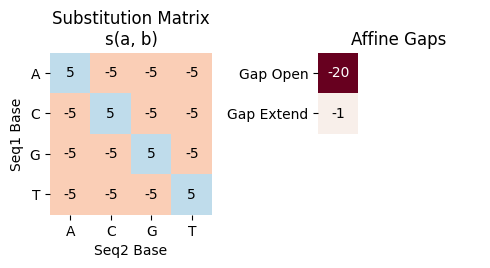

In [ ]:
# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from nwflex.validation import (
    get_default_scoring,
    nwg_global,
    check_standard_case,
    check_AZB_case,
    check_alignment_validity,
    run_mutated_AZB_tests,
)
from nwflex.aligners import align_single_block
from nwflex.ep_patterns import build_EP_single_block
from nwflex.plot import (
    plot_score_system,
    plot_ep_pattern,
    draw_ep_background,
    plot_flex_matrices_publication,
    REGION_FILL_COLORS,
    REGION_LABEL_COLORS,
)

from nwflex.plot.colors import HEATMAP_COLORMAPS
grid_color_map = HEATMAP_COLORMAPS['diverging']

# ===============================================================================
# Global test parameters — adjust these to control validation thoroughness
# ===============================================================================
NUM_MUTATION_VARIANTS = 100   # Number of mutated Y variants per base case
NUM_RANDOM_CASES = 100        # Number of random A·Z·B tests to run
NUM_SCORING_TESTS = 100       # Number of tests per scoring scheme variant

# Load default scoring
score_matrix, gap_open, gap_extend, alphabet_to_index = get_default_scoring()

# Show the scoring system
fig = plot_score_system(score_matrix, gap_open, gap_extend, alphabet_to_index)
plt.show()

## Base case: NW-flex with no extra predecessors

As a sanity check, we first verify that NW-flex with $E(i) = \varnothing$ for
all rows (via `align_standard`) gives the same score as the independent
Needleman–Wunsch/Gotoh implementation `nwg_global`. The helper 
`check_standard_case` runs both and returns their scores for comparison.

This confirms that our DP core is correct before we add extra predecessors.

In [2]:
# Test cases covering different alignment scenarios:
# - Identical sequences (perfect match)
# - Single deletion (one base missing in Y)
# - Substitution (one mismatch)
# - Multiple gaps (contraction/expansion)
# - Mixed operations (substitution + indel)

examples = [
    ("GATTACA", "GATTACA", "identical"),
    ("GATTACA", "GATACA", "single deletion"),
    ("ACGT", "ACCT", "single substitution"),
    ("GGGATATGGG", "GGGATGGG", "internal deletion"),
    ("AACGT", "ACGTT", "deletion + insertion"),
]

results = []
for X, Y, desc in examples:
    flex_score, nwg_score = check_standard_case(X, Y)
    match = "[OK]" if flex_score == nwg_score else "[FAIL]"
    results.append({
        "case": desc, "X": X, "Y": Y, 
        "flex": int(flex_score), "nwg": int(nwg_score), "match": match
    })
    assert flex_score == nwg_score, "Standard NW-flex != nwg_global!"

df = pd.DataFrame(results)
print("Standard NW-flex matches nwg_global on all examples:")
print()
print(df.to_string(index=False))
print()
print("[OK] All base case tests passed.")

Standard NW-flex matches nwg_global on all examples:

                case          X        Y  flex  nwg match
           identical    GATTACA  GATTACA    35   35  [OK]
     single deletion    GATTACA   GATACA    10   10  [OK]
 single substitution       ACGT     ACCT    10   10  [OK]
   internal deletion GGGATATGGG GGGATGGG    19   19  [OK]
deletion + insertion      AACGT    ACGTT    -5   -5  [OK]

[OK] All base case tests passed.


## Single-block validation: explicit $A \cdot Z \cdot B$ example

We now validate the core claim: for references of the form
$$
X = A \cdot Z \cdot B,
$$
the single-block NW-flex configuration returns
$$
S_{\mathrm{flex}}(X, Y) = \max_{Z^{*} \subseteq Z} \mathrm{NWG}(A \cdot Z^{*} \cdot B,\; Y).
$$

### Defining the test sequences

In [3]:
# Define a small A·Z·B example
# Reference X and read Y
A = "ACT"
Z = "GATTACA"
B = "CAT"

X = A + Z + B
Zstar = "TTA"
Y = A + Zstar + B

print("A:", A)
print("Z:", Z)
print("B:", B)
print("X (reference):", X)
print("Y (read):     ", Y)

# Block boundary indices
s = len(A)          # leader row (last row of A)
e = len(A) + len(Z) # end of Z; closer row is e+1
n = len(X)

print(f"\nBlock indices: s = {s}, e = {e}")
print(f"  A = X[0:{s}] = '{X[:s]}'")
print(f"  Z = X[{s}:{e}] = '{X[s:e]}'")
print(f"  B = X[{e}:{n}] = '{X[e:]}'")
print(f"  Leader row: {s}, Closer row: {e+1}")

A: ACT
Z: GATTACA
B: CAT
X (reference): ACTGATTACACAT
Y (read):      ACTTTACAT

Block indices: s = 3, e = 10
  A = X[0:3] = 'ACT'
  Z = X[3:10] = 'GATTACA'
  B = X[10:13] = 'CAT'
  Leader row: 3, Closer row: 11


### The single-block EP pattern

Before running the alignment, let's visualize the extra-predecessor pattern
$E(i)$ for this single-block configuration:

- Rows inside $Z$ (rows $s{+}1$ to $e$) have $E(i) = \{s\}$: they can jump
  from the **leader** row $s$.
- The **closer** row $e{+}1$ has $E(e{+}1) = \{s, s{+}1, \ldots, e\}$: it can
  jump from the leader or any row in $Z$.
- All other rows have $E(i) = \varnothing$.

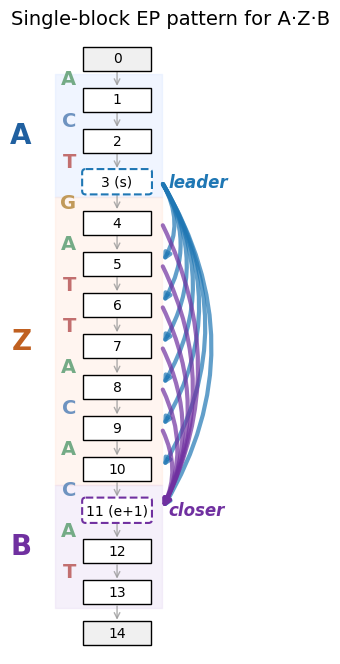

In [4]:
# Build the EP pattern
EP = build_EP_single_block(n=n, s=s, e=e)

# Define A·Z·B region colors (matching notebook 02)
color_A, color_Z, color_B = "#d0e0ff", "#ffe0d0", "#e0d0f0"
label_A, label_Z, label_B = "#2060a0", "#c06020", "#7030a0"

regions = [
    {'start': 1, 'end': s, 'color': color_A, 'label': 'A', 'label_color': label_A},
    {'start': s + 1, 'end': e, 'color': color_Z, 'label': 'Z', 'label_color': label_Z},
    {'start': e + 1, 'end': n, 'color': color_B, 'label': 'B', 'label_color': label_B},
]

# Visualize the pattern with A·Z·B region shading (matching notebook 02 style)
fig, ax = plot_ep_pattern(
    EP=EP,
    leaders=[s],
    X=X,
    title="Single-block EP pattern for A·Z·B",
    figsize=(5, 8),
    row_annotations={s: "(s)", e+1: "(e+1)"},
    node_height=0.7,
    row_spacing=1.2,
    node_width=2.0,
    sequence_fontsize=14.0,
    row_label_fontsize=10.0,
    sequence_fontweight="semibold",
    ep_linewidth=3.0,
    box_label_fontsize=12.0,
)

# Add the A·Z·B background regions
draw_ep_background(
    ax, n,
    regions=regions,
    row_spacing=1.2,
    node_height=0.7,
    node_width=2.0,
    region_fontsize=20.0,
    region_fontweight="bold",
)

plt.show()

### Enumerate all substrings $Z^{*}$ and compute NWG scores

The naive baseline enumerates all contiguous substrings
$Z^{*} = X[i:j]$ with $s \le i \le j \le e$,
forms the effective reference $X' = A \cdot Z^{*} \cdot B$,
and computes $\mathrm{NWG}(X', Y)$.

The flex optimum is the maximum over all such substrings.

In [5]:
naive_rows = []
best_score = -np.inf
best_pairs = []

for i in range(s, e + 1):
    for j in range(i, e + 1):
        Z_star = X[i:j]            # contiguous substring of Z
        X_prime = A + Z_star + B   # effective reference
        score = nwg_global(
            X_prime, Y,
            score_matrix, gap_open, gap_extend, alphabet_to_index,
        )
        naive_rows.append((i, j, Z_star, X_prime, score))
        if score > best_score:
            best_score = score
            best_pairs = [(i, j, Z_star, X_prime)]
        elif score == best_score:
            best_pairs.append((i, j, Z_star, X_prime))

# Build DataFrame for display
df_naive = pd.DataFrame(naive_rows, columns=["i", "j", "Z*", "X'=A·Z*·B", "score"])

# Mark optimal rows
df_naive["opt"] = df_naive["score"].apply(lambda x: "*" if x == best_score else "")

print(f"Naive enumeration of Z* substrings (best score = {int(best_score)}):")
print()
print(df_naive.to_string(index=False))

print(f"Total of {len(naive_rows)} Z* substrings evaluated.")
print(f"Total of {len(set(df_naive['Z*']))} distinct substrings evaluated.")

print(f"\nOptimal Z* choices achieving score {int(best_score)}:")
for i, j, zst, xp in best_pairs:
    print(f"  Z* = '{zst}' → X' = '{xp}'")

Naive enumeration of Z* substrings (best score = 45):

 i  j      Z*     X'=A·Z*·B  score opt
 3  3                ACTCAT    8.0    
 3  4       G       ACTGCAT    4.0    
 3  5      GA      ACTGACAT   10.0    
 3  6     GAT     ACTGATCAT   15.0    
 3  7    GATT    ACTGATTCAT    5.0    
 3  8   GATTA   ACTGATTACAT   24.0    
 3  9  GATTAC  ACTGATTACCAT    4.0    
 3 10 GATTACA ACTGATTACACAT    3.0    
 4  4                ACTCAT    8.0    
 4  5       A       ACTACAT   14.0    
 4  6      AT      ACTATCAT   10.0    
 4  7     ATT     ACTATTCAT   25.0    
 4  8    ATTA    ACTATTACAT   25.0    
 4  9   ATTAC   ACTATTACCAT    5.0    
 4 10  ATTACA  ACTATTACACAT   13.0    
 5  5                ACTCAT    8.0    
 5  6       T       ACTTCAT   14.0    
 5  7      TT      ACTTTCAT   20.0    
 5  8     TTA     ACTTTACAT   45.0   *
 5  9    TTAC    ACTTTACCAT   25.0    
 5 10   TTACA   ACTTTACACAT   24.0    
 6  6                ACTCAT    8.0    
 6  7       T       ACTTCAT   14.0    
 6  8    

The table above shows all 36 possible substrings $Z^{*}$ of $Z = \texttt{GATTACA}$ (26 unique).
The asterisks mark the optimal choice(s).

In this example, the best substring is $Z^{*} = \texttt{TTA}$ ($i=5; j=8$).

This yields $X' = \texttt{ACTTTACAT}$ — an exact match with the read $Y$
resulting in the highest possible score, $9 \times 5 = 45$ (all matches, no gaps).

### Single-block NW-flex on the same example

Now we run NW-flex with the single-block EP pattern on the same $(X, Y, s, e)$
and verify that it achieves the same score as the naive maximum.

In [6]:
res_blk = align_single_block(
    X=X, Y=Y, s=s, e=e,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    alphabet_to_index=alphabet_to_index,
    return_data=True,
)

print(f"NW-flex single-block score: {res_blk.score}")
print(f"Naive maximum score:        {best_score}")
print()
print("NW-flex alignment:")
print(f"  X_aln: {res_blk.X_aln}")
print(f"  Y_aln: {res_blk.Y_aln}")

assert res_blk.score == best_score, "NW-flex score does not match naive maximum!"
print("\n[OK] NW-flex single-block score equals the naive max over Z*.")

NW-flex single-block score: 45.0
Naive maximum score:        45.0

NW-flex alignment:
  X_aln: ACTTTACAT
  Y_aln: ACTTTACAT

[OK] NW-flex single-block score equals the naive max over Z*.


## Systematic validation with `check_AZB_case`

We have shown score equality on one explicit example. Now we use the helper
`check_AZB_case(A, Z, B, Y)` to run both NW-flex and the naive baseline on
multiple test cases.

### Manual test cases

In [7]:
# Interesting test cases that exercise different aspects of flex alignment:
manual_cases = [
    # (A, Z, B, Y, description)
    # Case 1: Read matches a proper substring of Z (contraction)
    ("ACG", "TATATAT", "ACG", "ACGTATACG",
     "Y has shorter repeat than Z"),
    # Case 2: Read matches flanks but skips Z entirely (Z* = ε)
    ("GATTACA", "CCCC", "GATTACA", "GATTACAGATTACA",
     "Y skips Z entirely"),
    # Case 3: Read has insertion relative to best Z* 
    ("AT", "GCGCGC", "AT", "ATGCGGGCGCAT",
     "Y has insertion in Z region"),
    # Case 4: Z contains repeats, Y matches subset
    ("CAT", "AGAGAGAG", "CAT", "CATAGAGCAT",
     "Y matches partial repeat"),
    # Case 5: Flanks have mismatches, Z must compensate
    ("AAAA", "TGTGTG", "CCCC", "AAAATGTCCCC",
     "Flanks match, Z contracts"),
    # Case 6: Complex case with all features
    ("GCAT", "ATATATATAT", "GCAT", "GCATATATGCAT",
     "STR-like contraction"),
]

results = []
for A0, Z0, B0, Y0, desc in manual_cases:
    flex_score, naive_score = check_AZB_case(A0, Z0, B0, Y0)
    match = "[OK]" if flex_score == naive_score else "[FAIL]"
    results.append({
        "description": desc,
        "A": A0, "Z": Z0, "B": B0, "Y": Y0,
        "flex": int(flex_score), "naive": int(naive_score), "match": match
    })
    assert flex_score == naive_score, f"Mismatch: A={A0}, Z={Z0}, B={B0}, Y={Y0}"

df = pd.DataFrame(results)
print("Manual A·Z·B test cases: NW-flex vs naive baseline")
print()
print(df.to_string(index=False))
print()
print("[OK] All manual test cases passed.")

Manual A·Z·B test cases: NW-flex vs naive baseline

                description       A          Z       B              Y  flex  naive match
Y has shorter repeat than Z     ACG    TATATAT     ACG      ACGTATACG    45     45  [OK]
         Y skips Z entirely GATTACA       CCCC GATTACA GATTACAGATTACA    70     70  [OK]
Y has insertion in Z region      AT     GCGCGC      AT   ATGCGGGCGCAT    29     29  [OK]
   Y matches partial repeat     CAT   AGAGAGAG     CAT     CATAGAGCAT    50     50  [OK]
  Flanks match, Z contracts    AAAA     TGTGTG    CCCC    AAAATGTCCCC    55     55  [OK]
       STR-like contraction    GCAT ATATATATAT    GCAT   GCATATATGCAT    60     60  [OK]

[OK] All manual test cases passed.


### Manual test cases with mutations

To stress-test the validation further, we introduce random mutations to the 
read sequence $Y$ from each base case above.   
The `run_mutated_AZB_tests` 
function generates mutated variants by applying:

- **Substitutions** at rate 15% per base (each base has a 15% chance of being 
  replaced by a different nucleotide),
- **Insertions** at rate 8% per base (random base inserted after),
- **Deletions** at rate 8% per base (base removed).

For each of the 6 manual cases, we generate 100 mutated variants of $Y$ and 
verify that NW-flex still matches the naive baseline on every mutated input.

In [8]:
# Run mutated tests on the interesting cases
results = run_mutated_AZB_tests(
    manual_cases, 
    num_mutations=NUM_MUTATION_VARIANTS, 
    sub_rate=0.15, 
    indel_rate=0.08,
    seed=888,
)

df_mutated = pd.DataFrame(results)

# Summary statistics
n_total = len(df_mutated)
n_match = df_mutated["match"].sum()

print(f"Mutated sequence validation: {n_match}/{n_total} tests passed")
print(f"Substitution rate: 15%, Indel rate: 8%")
print()

# Aggregate by base case (description, A, Z, B, Y), preserving original order
summary = (
    df_mutated
    .groupby(["description", "A", "Z", "B", "Y"], sort=False)
    .agg(passed=("match", "sum"), total=("match", "count"))
    .reset_index()
)

def format_result(r):
    if r['passed'] == r['total']:
        return f"[OK] {r['passed']}/{r['total']}"
    else:
        return f"[FAIL] {r['passed']}/{r['total']}"

summary["result"] = summary.apply(format_result, axis=1)

print(f"Mutation test summary by base case ({n_match}/{n_total} total passed):")
print()
cols = ["description", "A", "Z", "B", "Y", "result"]
print(summary[cols].to_string(index=False))

Mutated sequence validation: 600/600 tests passed
Substitution rate: 15%, Indel rate: 8%

Mutation test summary by base case (600/600 total passed):

                description       A          Z       B              Y       result
Y has shorter repeat than Z     ACG    TATATAT     ACG      ACGTATACG [OK] 100/100
         Y skips Z entirely GATTACA       CCCC GATTACA GATTACAGATTACA [OK] 100/100
Y has insertion in Z region      AT     GCGCGC      AT   ATGCGGGCGCAT [OK] 100/100
   Y matches partial repeat     CAT   AGAGAGAG     CAT     CATAGAGCAT [OK] 100/100
  Flanks match, Z contracts    AAAA     TGTGTG    CCCC    AAAATGTCCCC [OK] 100/100
       STR-like contraction    GCAT ATATATATAT    GCAT   GCATATATGCAT [OK] 100/100


### Randomized test cases

We generate small random $A \cdot Z \cdot B$ examples and verify that
NW-flex always matches the naive baseline. Sequences are kept short
so that the $O(|Z|^2)$ naive enumeration remains fast.

In [9]:
DNA = "ACGT"

def random_dna(rng, length: int) -> str:
    return "".join(rng.choice(list(DNA)) for _ in range(length))

def run_random_AZB_tests(num_cases: int = 20, seed: int = 0):
    """Run randomized A·Z·B validation tests."""
    rng = np.random.default_rng(seed)
    for idx in range(num_cases):
        # Random lengths (small to keep naive enumeration cheap)
        len_A = rng.integers(4, 6)
        len_Z = rng.integers(4, 10)
        len_B = rng.integers(4, 6)
        len_Y = rng.integers(6, 10)

        A0 = random_dna(rng, len_A)
        Z0 = random_dna(rng, len_Z)
        B0 = random_dna(rng, len_B)
        Y0 = random_dna(rng, len_Y)

        flex_score, naive_score = check_AZB_case(A0, Z0, B0, Y0)
        if flex_score != naive_score:
            print(f"Mismatch: A={A0}, Z={Z0}, B={B0}, Y={Y0}")
            print(f"  flex={flex_score}, naive={naive_score}")
            raise AssertionError("Random A·Z·B test failed.")    
    print(f"[OK] All {num_cases} random A·Z·B tests passed.")
    

In [10]:
random_seed = random.randint(0, 10000)
print(f"Random seed: {random_seed}")
run_random_AZB_tests(num_cases=NUM_RANDOM_CASES, seed=random_seed)

Random seed: 6199
[OK] All 100 random A·Z·B tests passed.


## Alignment string comparison

So far we have validated that **scores** match. The paper also claims that
**alignments** are valid. We use `check_alignment_validity` to verify that the
aligned sequences from NW-flex are consistent with the naive baseline.

Note: there may be multiple optimal alignments with the same score. We verify
that both methods produce valid alignments achieving the optimal score,
not necessarily that they produce *identical* alignment strings.

In [11]:
# Test alignment validity on our explicit example
res = align_single_block(
    X=A + Z + B,
    Y=Y,
    s=len(A),
    e=len(A) + len(Z),
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    alphabet_to_index=alphabet_to_index,
)

valid, msg = check_alignment_validity(res)

print("Alignment validation for explicit example:")
print(f"  A = '{A}', Z = '{Z}', B = '{B}', Y = '{Y}'")
print()
print(f"NW-flex alignment (score = {res.score}):")
print(f"  X_aln: {res.X_aln}")
print(f"  Y_aln: {res.Y_aln}")
print()
print(f"Validity check: {msg}")
if valid:
    print("[OK] Alignment validation passed.")

Alignment validation for explicit example:
  A = 'ACT', Z = 'GATTACA', B = 'CAT', Y = 'ACTTTACAT'

NW-flex alignment (score = 45.0):
  X_aln: ACTTTACAT
  Y_aln: ACTTTACAT

Validity check: Valid alignment of length 9
[OK] Alignment validation passed.


### Testing with different scoring schemes

The paper states that validation was performed "across a range of scoring
schemes." We verify score equality with alternative gap penalties.

In [ ]:
# Alternative scoring schemes to test
scoring_variants = [
    ("Default", score_matrix, -20.0, -1.0),
    ("Smaller gap open", score_matrix, -10.0, -1.0),
    ("Larger gap extend", score_matrix, -20.0, -3.0),
    ("Balanced gaps", score_matrix, -4.0, -4.0),
]

results = []
for name, sm, go, ge in scoring_variants:
    # Run a few random tests with this scoring
    rng = np.random.default_rng(888)
    
    passed = 0
    for _ in range(NUM_SCORING_TESTS):
        len_A = rng.integers(4, 6)
        len_Z = rng.integers(4, 10)
        len_B = rng.integers(4, 6)
        len_Y = rng.integers(6, 10)

        A0 = random_dna(rng, len_A)
        Z0 = random_dna(rng, len_Z)
        B0 = random_dna(rng, len_B)
        Y0 = random_dna(rng, len_Y)
        
        flex_score, naive_score = check_AZB_case(
            A0, Z0, B0, Y0,
            score_matrix=sm,
            gap_open=go,
            gap_extend=ge,
        )
        if flex_score == naive_score:
            passed += 1
    
    status = "[OK]" if passed == NUM_SCORING_TESTS else "[FAIL]"
    results.append({
        "scheme": name,
        "gap_open": int(go),
        "gap_extend": int(ge),
        "result": f"{status} {passed}/{NUM_SCORING_TESTS}"
    })

df_scoring = pd.DataFrame(results)
n_tests = NUM_SCORING_TESTS
print(f"Validation with different scoring schemes ({n_tests} random tests each):")
print()
print(df_scoring.to_string(index=False))

Validation with different scoring schemes (100 random tests each):

           scheme  gap_open  gap_extend       result
          Default       -20          -1 [OK] 100/100
 Smaller gap open       -10          -1 [OK] 100/100
Larger gap extend       -20          -3 [OK] 100/100
    Balanced gaps        -4          -4 [OK] 100/100


## Visualizing the DP matrices and row jumps

For the explicit $A \cdot Z \cdot B$ example, we visualize the DP matrices
and the optimal path to see how NW-flex realizes the substring selection.

The path shows:
- Standard DP in the flank $A$,
- A jump from the leader row $s$ into the flex block $Z$,
- Standard DP within the chosen substring $Z^{*}$,
- A jump from $Z$ to the closer row $e{+}1$,
- Standard DP in the flank $B$.

The **row jumps** reveal which substring $Z^{*}$ was selected. From the jump
coordinates we can recover the optimal indices $(a, b)$ such that
$Z^{*} = Z[a:b]$ (in Python slice notation):

- The **entry jump** (into $Z$) lands at row $i_{\mathrm{in}}$; the start index
  is $a = i_{\mathrm{in}} - s - 1$.
- The **exit jump** (to the closer row $e{+}1$) departs from row $i_{\mathrm{out}}$;
  the end index is $b = i_{\mathrm{out}} - s$.

Row jumps in the optimal path:
  Row 3 → Row 6 at column 4
  Row 8 → Row 11 at column 7

Recovered Z* indices from jumps:
  Entry jump lands at row 6 → a = 6 - 3 - 1 = 2
  Exit jump departs from row 8 → b = 8 - 3 = 5
  Z[2:5] = 'TTA'

Verification: Z* = 'TTA' matches the optimal substring.


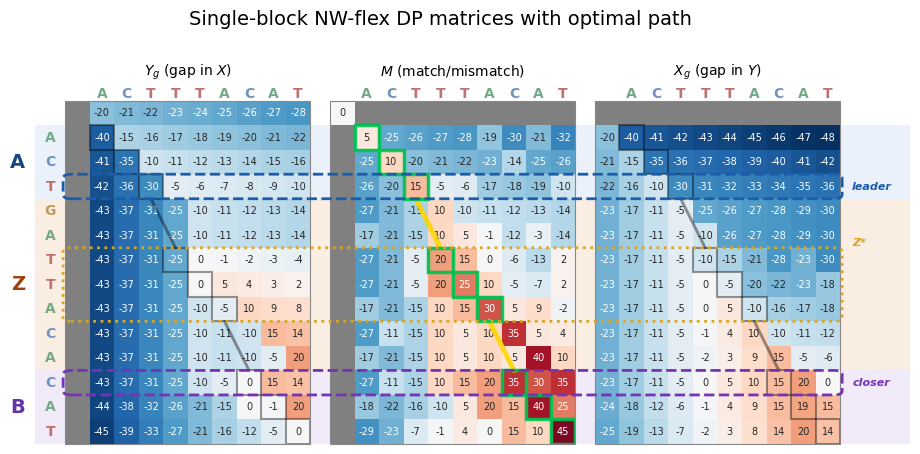

In [13]:
# Show row jumps from the alignment result
print("Row jumps in the optimal path:")
if res_blk.jumps:
    for jump in res_blk.jumps:
        print(f"  Row {jump.from_row} → Row {jump.to_row} at column {jump.col}")
else:
    print("  (no jumps — alignment stayed within standard predecessor structure)")

# Convert jump coordinates to Z* indices
# Entry jump: from leader s into Z; exit jump: from Z to closer e+1
zstar_rows = None
if len(res_blk.jumps) >= 2:
    entry_jump = res_blk.jumps[0]  # jump into Z
    exit_jump = res_blk.jumps[1]   # jump out of Z to closer
    
    # a = first row of Z* relative to Z (0-indexed into Z)
    # b = one past last row of Z* relative to Z
    a = entry_jump.to_row - s - 1
    b = exit_jump.from_row - s
    
    print(f"\nRecovered Z* indices from jumps:")
    entry_row = entry_jump.to_row
    print(f"  Entry jump lands at row {entry_row} → a = {entry_row} - {s} - 1 = {a}")
    exit_row = exit_jump.from_row
    print(f"  Exit jump departs from row {exit_row} → b = {exit_row} - {s} = {b}")
    print(f"  Z[{a}:{b}] = '{Z[a:b]}'")
    zstar = Z[a:b]
    print(f"\nVerification: Z* = '{zstar}' matches the optimal substring.")
    
    # Store Z* row bounds for region annotation
    zstar_start = entry_jump.to_row
    zstar_end = exit_jump.from_row

# Build A·Z·B regions for background fills

regions = [
    {'start': 1, 'end': s, 'label': 'A',
     'fill_color': REGION_FILL_COLORS['A'], 'label_color': REGION_LABEL_COLORS['A']},
    {'start': s + 1, 'end': e, 'label': 'Z',
     'fill_color': REGION_FILL_COLORS['Z'], 'label_color': REGION_LABEL_COLORS['Z']},
    {'start': e + 1, 'end': n, 'label': 'B',
     'fill_color': REGION_FILL_COLORS['B'], 'label_color': REGION_LABEL_COLORS['B']},
] if s >= 1 else []

# Build Z* highlight (gold dotted box like leader/closer)
GOLD = '#DAA520'
row_highlights = []
if len(res_blk.jumps) >= 2:
    row_highlights.append({
        'start': zstar_start,
        'end': zstar_end,
        'label': 'Z*',
        'color': GOLD,
        'linestyle': ':',
        'label_position': 'top',
    })

# Create figure with GridSpec for the 3 matrices
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.08)
axes = [fig.add_subplot(gs[i]) for i in range(3)]

# Plot using publication-quality plotter
plot_flex_matrices_publication(
    fig=fig,
    axes=axes,
    result=res_blk,
    X=X,
    Y=Y,
    s=s,
    e=e,
    regions=regions,
    row_highlights=row_highlights,
    colormap=grid_color_map,
    title_pad=18,
)

fig.suptitle("Single-block NW-flex DP matrices with optimal path", fontsize=14, y=1.02)
plt.show()

## Summary

This notebook validated the core NW-flex optimality claim for the single-block
$A \cdot Z \cdot B$ configuration:

1. **Base case**: NW-flex with $E(i) = \varnothing$ matches an independent
   NWG implementation on all tested examples.

2. **Single-block flex**: NW-flex with the prescribed EP pattern achieves
   $$
   S_{\mathrm{flex}}(X, Y) = \max_{Z^{*} \subseteq Z} \mathrm{NWG}(A \cdot Z^{*} \cdot B,\; Y)
   $$
   on both hand-crafted and randomized test cases.

3. **Alignment correctness**: The alignment strings from NW-flex are valid
   and consistent with the naive baseline.

4. **Scoring robustness**: Score equality holds across different gap penalty
   configurations.

5. **Path interpretation**: The DP visualizations show how NW-flex realizes
   the optimal $Z^{*}$ via row jumps at the leader and closer boundaries.

This validates the flex optimality guarantee for single-block configurations.
In **Notebook 4**, we build on this foundation to handle STR-specific EP
patterns with motif phase constraints.